# Behavioral Cloning - Deep Learning Model



Standard Deviation of angles =  6.32666353942


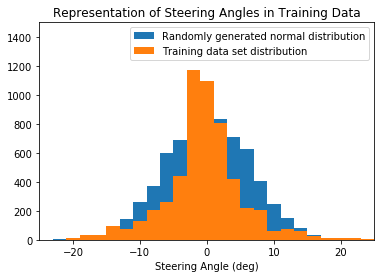

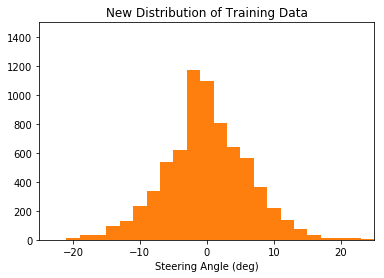

In [8]:
### Load csv file containing image file paths and associated steering angles

import numpy as np
import tensorflow as tf
import os
import csv
import sklearn
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIR = '../linux_sim/DriveALL/'

samples = []
with open(DATA_DIR + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


# Plot histogram of steering angle in data
samples = sklearn.utils.shuffle(samples)
list_steering_angles = [57.3*float(sample[3]) for sample in samples]


data_std = np.std(list_steering_angles)
print('Standard Deviation of angles = ',data_std)
n_normal, bins, patches = plt.hist(data_std * np.random.randn(int(1.3*len(list_steering_angles))),bins=range(-25,26,2))

n_data, bins, patches = plt.hist(list_steering_angles,bins=range(-25,26,2))
plt.axis([-25,25,0,1500])
plt.title('Representation of Steering Angles in Training Data')
plt.xlabel('Steering Angle (deg)')
plt.legend(['Randomly generated normal distribution','Training data set distribution'],loc='best')


# Duplicate and delete data points to form a more normal distribution of steering angles
list_to_remove = []
for b in range(1,len(bins)-1):
    if n_normal[b] < 5:
        percent_off = 0   #Avoid dividing by zero, and small bins
    else:
        percent_off = (n_data[b] - n_normal[b]) / n_normal[b]
    
    idx = 0
    while abs(percent_off) > 0.10:
        
        # find next index within current bin
        if bins[b] < list_steering_angles[idx] and list_steering_angles[idx] < bins[b+1]:
            
            # Duplicate or remove data sample to get closer to normal distribution
            if percent_off < 0:
                # Duplicate sample
                samples.append(samples[idx])
                # Update percent_off
                percent_off = (percent_off * n_normal[b] + 1) / n_normal[b]
                #print('Sample added to bin', bins[b]/57.3)
                #print('Value = ',list_steering_angles[idx]/57.3)
                #print(samples[idx])
                
            elif percent_off > 0:
                #print('Sample removed from bin', bins[b]/57.3)
                #print('Value = ',list_steering_angles[idx]/57.3)
                #print(samples[idx])
                # Remove sample
                list_to_remove.append(idx)
                # Update percent_off
                percent_off = (percent_off * n_normal[b] - 1) / n_normal[b]
                
            
        # Advance index
        idx += 1
        
        # Loop back through list if necessary
        if idx == len(list_steering_angles):
            idx = 0


#for idx in sorted(list_to_remove, reverse=True):
    #del(samples[idx])

samples = sklearn.utils.shuffle(samples)
    

# Replot histogram of updated samples set
plt.figure()
list_steering_angles = [57.3*float(sample[3]) for sample in samples]
plt.hist(list_steering_angles,bins=range(-25,26,2))
plt.hist(list_steering_angles,bins=range(-25,26,2))
plt.axis([-25,25,0,1500])
plt.title('New Distribution of Training Data')
plt.xlabel('Steering Angle (deg)')
            

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)





### Data Augmentation Functions
Functions which may be called in the batch generator below for data augmentation to increase variablity in the training set. Each function applies their transformations with randomness.

In [9]:
from numpy.random import rand

def image_offset(image):
    # Applies both a random vertical and random lateral offset to image
    # Pixels within the frame which no longer contain the image will be set to [0,0,0] (black)
    # Lateral offsets will return corresponding delta steering angle shift, no shift for vertical offsets
    
    VERT_RANGE = 50
    LAT_RANGE = 50
    
    vert_offset = (rand() - 0.5) * VERT_RANGE
    lat_offset = (rand() - 0.5) * LAT_RANGE
    
    # Delta steering angle is a linear function of lateral offset
    delta_angle = -0.009 * lat_offset
    
    # Offset image with OpenCV Translation
    rows,cols,chan = image.shape
    M = np.float32([[1,0,lat_offset],[0,1,vert_offset]])  #transformation matrix
    offset_image = cv2.warpAffine(image,M,(cols,rows))
    
    return offset_image, delta_angle
    

def image_rotate(image):
    # Rotates image by a random angle within +/-20 degrees, no steering angle change
    
    MAX_ROTATION = 20  #degrees
    
    rotation_angle = (rand() - 0.5) * 2 * MAX_ROTATION
    
    # Rotate image with OpenCV Rotation
    rows,cols,chan = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), rotation_angle, 1)  #rotation matrix (about center, scale = 1)
    rotated_image = cv2.warpAffine(image,M,(cols,rows))
    
    return rotated_image


def image_flip(image):
    # Flips an image horizontally with a random probability
    # Returns sign of the steering angle due to flip/no-flip
    
    FLIP_PROB = 0.5
    
    if rand() < FLIP_PROB:
        flipped_image = cv2.flip(image,1)
        return flipped_image, -1
    else:
        return image, 1


    

### Data Preprocessing Functions
Functions to preprocess images before being input to the model

In [10]:

def image_mask(image):
    # Masks regions of the image which may contain distracting/unnecessary content
    
    masked_image = image.copy()
    
    return masked_image

    

### Batch Generator
Loads each batch of training data as needed. Data augmentation and preprocessing will be applied as the data is loaded.

In [11]:
import cv2
import sklearn

BATCH_SIZE = 16

def generator(samples, batch_size=BATCH_SIZE):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        
        sklearn.utils.shuffle(samples)
        
        # Generate batch of data
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # Extract steering angle
                center_angle = float(batch_sample[3])
                
                # Load image
                random_value = rand()
                if random_value < 0.333: 
                    center_name = DATA_DIR+'IMG/'+batch_sample[0].split('/')[-1]
                    car_image = cv2.imread(center_name)
                    steer_angle = center_angle
                elif random_value < 0.667:
                    left_name = DATA_DIR+'IMG/'+batch_sample[1].split('/')[-1]
                    car_image = cv2.imread(left_name)
                    steer_angle = center_angle + 0.25
                else:
                    right_name = DATA_DIR+'IMG/'+batch_sample[2].split('/')[-1]
                    car_image = cv2.imread(right_name)
                    steer_angle = center_angle - 0.25
                
                
                
                ### Data augmentation

                # Flip image
                car_image, sign_angle = image_flip(car_image)
                steer_angle = sign_angle * steer_angle

                # Lateral & Vertical Offsets
                car_image, delta_angle = image_offset(car_image)
                steer_angle = steer_angle + delta_angle 



                # Limit steering angle to +/-25deg (=0.4363 rad)
                steer_angle = min(0.4363, max(-0.4363, steer_angle))
                
                images.append(car_image)
                angles.append(steer_angle)
                
            
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)




### Example of augmented training data

In [ ]:


#a,b = next(train_generator)
print('Image Shape = ',np.shape(a[0]))
#print(a)
#print(b)
bgr_image = (cv2.split(a[0]))
rgb_image = cv2.merge(bgr_image[::-1])

rgb_image, delta_angle = image_offset(rgb_image)
rgb_image = image_rotate(rgb_image)
rgb_image, sign_angle = image_flip(rgb_image)
plt.imshow(rgb_image)
plt.title('Steering Angle = ' + str(sign_angle * (b[0] + delta_angle)))
plt.show()

### Keras Model Definition


In [12]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras import backend as K


row, col, ch = 160, 320, 3  # Trimmed image format

model = Sequential()

# Crop top and bottom off image and resize to reduce computation time
model.add(Cropping2D(cropping=((35,25), (0,0)), input_shape=(row, col, ch)))
model.add(Lambda(lambda image: K.tf.image.resize_images(image, (64,64))))

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.))

# Nvidia-style normalized input planes
model.add(Convolution2D(3, 1, 1))  #1x1 for color mapping

# 3 Convolution 3x3 layers followed by a Max Pool
model.add(Convolution2D(16, 3, 3))  #3x3 
model.add(Convolution2D(16, 3, 3))  #3x3
model.add(Convolution2D(16, 3, 3))  #3x3
model.add(MaxPooling2D((2, 2)))     #2x2 Max Pool
model.add(Dropout(0.3))             #Dropout - keep 30%

# 3 more Convolutional 3x3 layers 
model.add(Convolution2D(32, 3, 3))  #3x3
model.add(Convolution2D(32, 3, 3))  #3x3
model.add(Convolution2D(16, 3, 3))  #3x3
model.add(Dropout(0.3))             #Dropout - keep 30%

# Flatten and 2 hidden layers before final dense layer
model.add(Flatten())
model.add(Dense(15))
model.add(Dense(35))
model.add(Dense(1))


### Model Training

In [13]:
# Train model using Mean Squared Error function
model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= \
            len(train_samples), validation_data=validation_generator, \
            nb_val_samples=len(validation_samples), nb_epoch=7, verbose=1)

# Save trained model
model.save('model.h5')

Epoch 1/7
5764/5764 [==============================] - 11s - loss: 0.0589 - val_loss: 0.0349
Epoch 2/7
5764/5764 [==============================] - 11s - loss: 0.0334 - val_loss: 0.0281
Epoch 3/7
5764/5764 [==============================] - 11s - loss: 0.0296 - val_loss: 0.0292
Epoch 4/7
5764/5764 [==============================] - 11s - loss: 0.0285 - val_loss: 0.0263
Epoch 5/7
5764/5764 [==============================] - 11s - loss: 0.0272 - val_loss: 0.0270
Epoch 6/7
5764/5764 [==============================] - 11s - loss: 0.0270 - val_loss: 0.0280
Epoch 7/7
5764/5764 [==============================] - 11s - loss: 0.0265 - val_loss: 0.0223


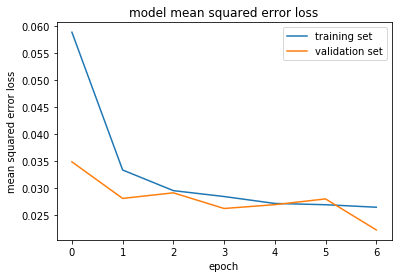

In [14]:
### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axis([0,4,0,2])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()